# Periodic Gene Expression Analysis

**Cell Cycle Gene Expression Clustering**

This notebook analyzes periodic gene expression patterns from cell cycle experiments. It includes expression profile visualization, peak detection using watershed-style algorithms, and identification of genes with similar temporal patterns.


## Imports / setup


In [68]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Loading and Inspecting the Data

This analysis uses the perturbed, cell-cycle–synchronized expression dataset from Dominguez *et al.* (2016), stored in the file `periodic_gene_expression.tsv`.

Each **row** in the file corresponds to a gene and is identified by its numerical ID. Each **column** represents a time point in the cell cycle experiment, with expression values measured at regular intervals.


In [69]:
# Path to the tab-separated periodic gene expression file
data_file_path = "../data/periodic_gene_expression.tsv"

# Load the expression matrix:
# - rows    = genes (index = gene IDs)
# - columns = cell-cycle time points
expr_df = pd.read_csv(
    data_file_path,
    sep="\t",
    header=None,
    index_col=0
)

# Inspect basic structure: (number of genes, number of time points)
expr_df.shape, expr_df.head()


((8813, 56),
          1         2         3         4         5         6         7   \
 0                                                                         
 0  0.132542  0.227641  0.148282  0.055420  0.173426  0.212824  0.295932   
 1  0.215197  0.378163  0.400179  0.173974  0.263814  0.556717  0.495361   
 2  0.122402  0.247476  0.231400  0.117036  0.180332  0.309252  0.367298   
 3  0.135091  0.249432  0.198000  0.088625  0.267934  0.382187  0.414468   
 4  0.163189  0.210381  0.223441  0.053721  0.155073  0.206997  0.281916   
 
          8         9         10  ...        47        48        49        50  \
 0                                ...                                           
 0  0.106484  0.053265  0.095814  ...  0.544871  0.620946  0.155174  0.451141   
 1  0.350477  0.029480  0.232456  ...  0.371614  0.449575  0.000000  0.217877   
 2  0.198849  0.018078  0.082632  ...  0.610129  0.539209  0.251884  0.478210   
 3  0.172162  0.151698  0.263706  ...  0.192407 

## Visualizing Periodic Expression Patterns

As a first analysis step, we plot the expression profiles of four selected genes together in one figure:

- gene **766**
- gene **932**
- gene **3297**
- gene **4685**

This allows us to visually compare their periodic patterns across the cell cycle.


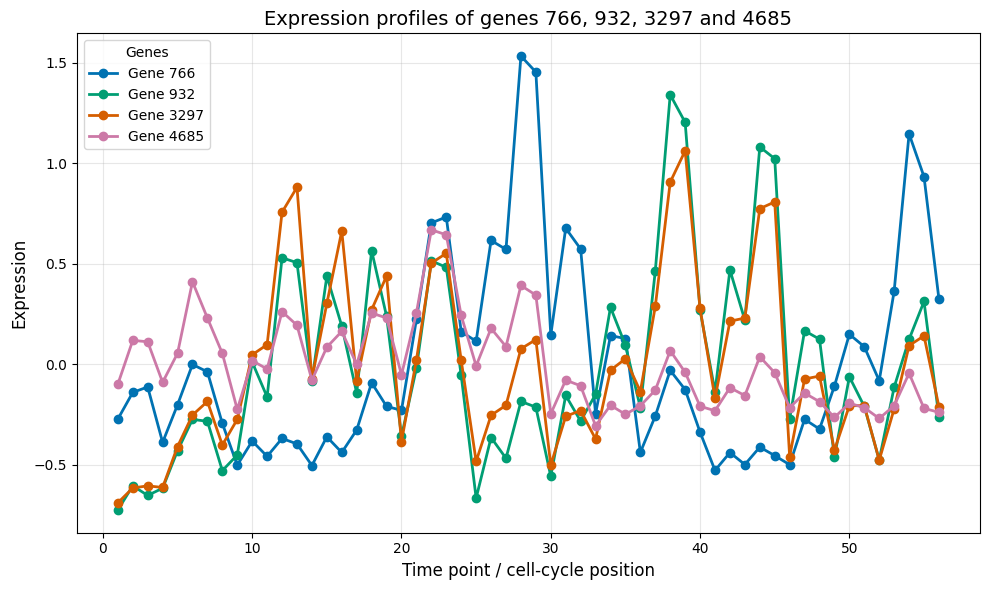

In [70]:
# IDs of the genes to be visualized (they are row indices in expr_df)
gene_ids = [766, 932, 3297, 4685]

# Extract the expression profiles of these genes and transpose:
# After transpose:
#   - rows    = time points
#   - columns = selected genes
expr_sub = expr_df.loc[gene_ids].T

plt.style.use("seaborn-v0_8-colorblind")
plt.figure(figsize=(10, 6))

# Plot each gene as a separate line
for gene_id in gene_ids:
    plt.plot(
        expr_sub.index,        # x-axis: time points (column indices)
        expr_sub[gene_id],     # y-axis: expression values
        marker="o",
        linewidth=2,
        label=f"Gene {gene_id}"
    )

plt.xlabel("Time point / cell-cycle position", fontsize=12)
plt.ylabel("Expression", fontsize=12)
plt.title("Expression profiles of genes 766, 932, 3297 and 4685", fontsize=14)

plt.grid(alpha=0.3)
plt.legend(title="Genes", fontsize=10)
plt.tight_layout()
plt.show()


## Watershed-Style Peak Detection

To automatically identify expression peaks along the cell cycle, we implement a simple **1D watershed-inspired** algorithm.

We treat the expression values of a single gene as a 1D landscape:

- High expression values correspond to "peaks" or "hills"
- Low expression values correspond to "valleys"

The algorithm identifies local maxima (peaks) by comparing each point to its neighbors within a specified adjacency threshold.


In [71]:
def detect_peaks_watershed_1d(signal, adjacency_threshold=1):
    """Watershed-like peak detection for 1D expression data.

    Parameters
    ----------
    signal : 1D array-like
        Expression values over time for a single gene. Values can be
        positive or negative; we will use their absolute values as
        "heights" to detect both positive and negative peaks.
    adjacency_threshold : int, optional
        How many time points earlier/later are considered "adjacent".
        For example:
            adjacency_threshold = 1  → neighbours: t-1, t+1
            adjacency_threshold = 2  → neighbours: t-2, t-1, t+1, t+2

    Returns
    -------
    labels : np.ndarray of shape (n_timepoints,)
        Integer label of the basin/peak that each time point belongs to.
        Time points with the same label are in the same peak basin.
    peak_indices : np.ndarray
        Positions (time indices) of the detected peaks.
    peak_values : np.ndarray
        Expression values of the original signal (with sign) at the
        peak positions.
    """

    # Ensure that we are working with a NumPy array
    signal = np.asarray(signal)
    n = signal.shape[0]             # number of time points

    # ------------------------------------------------------------
    # Step 1: Define the "height" of each time point as |signal|
    # ------------------------------------------------------------
    # We want to detect strong positive and strong negative peaks in
    # exactly the same way. Using the absolute value makes a large
    # negative value (deep valley) just as "high" as a large positive
    # value.
    heights = np.abs(signal)

    # ------------------------------------------------------------
    # Step 2: Process time points from highest |signal| to lowest
    # ------------------------------------------------------------
    # This is equivalent to lowering a water level from above the
    # maximum |signal| and letting the highest points emerge first.
    order = np.argsort(-heights)  # indices sorted in descending order

    # Initially, no time point belongs to any basin → label = -1
    labels = -1 * np.ones(n, dtype=int)

    # Next label to assign when a new basin is created
    next_label = 0

    # ------------------------------------------------------------
    # Step 3: Assign each time point to a basin
    # ------------------------------------------------------------
    for idx in order:
        # Determine the neighbourhood of idx according to the
        # adjacency_threshold. We clip to the valid index range.
        left = max(0, idx - adjacency_threshold)
        right = min(n - 1, idx + adjacency_threshold)
        neighbours = np.arange(left, right + 1)

        # Among these neighbours, consider only those that have already
        # been assigned to a basin (label != -1).
        labelled_neighbours = neighbours[labels[neighbours] != -1]

        if labelled_neighbours.size == 0:
            # Case 1: no labelled neighbours → start a new basin here.
            labels[idx] = next_label
            next_label += 1
        else:
            # Case 2: at least one labelled neighbour exists.
            # We attach this time point to the basin of the neighbour
            # with the highest height (= strongest signal).
            neighbour_heights = heights[labelled_neighbours]
            best_pos = np.argmax(neighbour_heights)
            best_neighbour = labelled_neighbours[best_pos]

            labels[idx] = labels[best_neighbour]

    # ------------------------------------------------------------
    # Step 4: For each basin, identify its peak coordinate
    # ------------------------------------------------------------
    unique_labels = np.unique(labels)

    peak_indices = []
    peak_values = []

    for lab in unique_labels:
        # All time points that belong to this basin
        positions = np.where(labels == lab)[0]
        basin_heights = heights[positions]

        # Peak = position with maximal |signal| within the basin
        best_pos = np.argmax(basin_heights)
        peak_idx = positions[best_pos]

        peak_indices.append(peak_idx)
        peak_values.append(signal[peak_idx])

    peak_indices = np.array(peak_indices, dtype=int)
    peak_values = np.array(peak_values)

    return labels, peak_indices, peak_values


## Peak Detection Application - Gene 766

We apply the `detect_peaks_watershed_1d` function to the expression profile of **gene 766** using different adjacency thresholds from 1 to 4:

- `adjacency_threshold = 1` → only directly adjacent time points are neighbors
- `adjacency_threshold = 2` → considers 2 time points on each side
- `adjacency_threshold = 3` → considers 3 time points on each side
- `adjacency_threshold = 4` → considers 4 time points on each side

This allows us to evaluate how the threshold affects peak detection sensitivity.


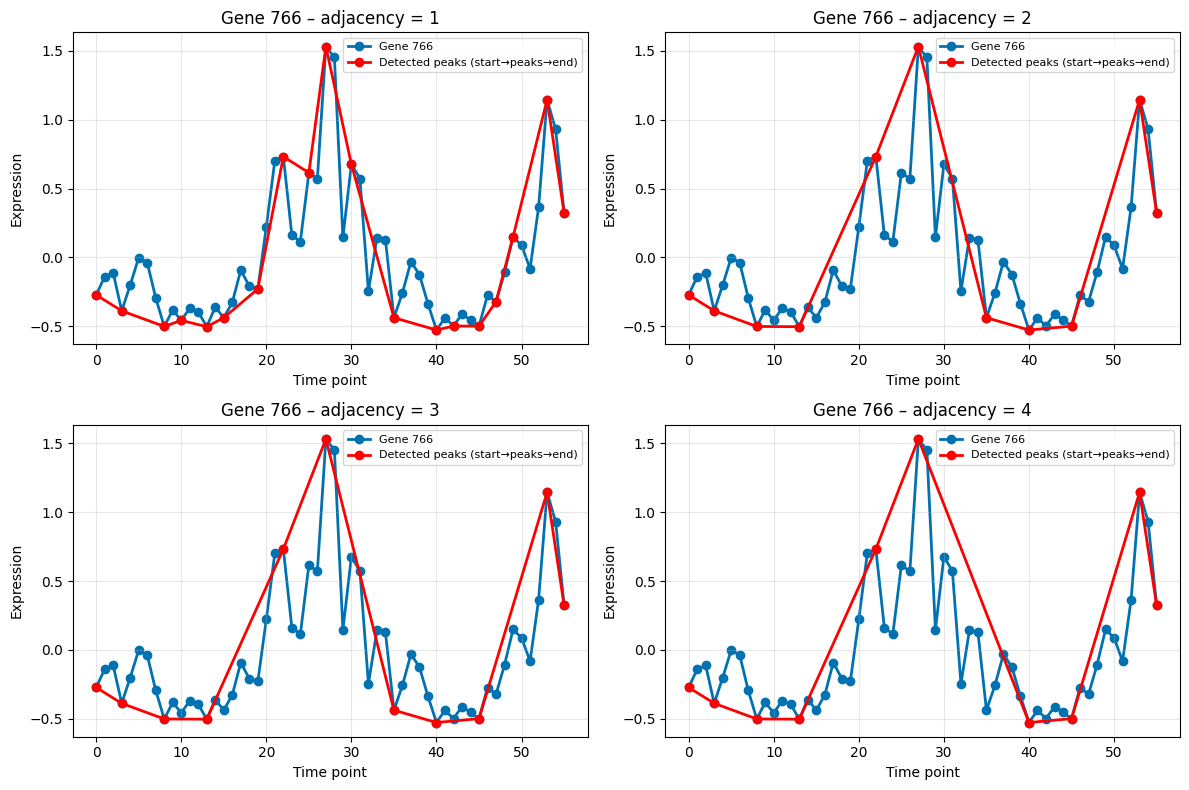

In [72]:
# Select the expression profile of gene 766
gene_id = 766
gene_expr = expr_df.loc[gene_id].to_numpy()
timepoints = np.arange(len(gene_expr))

adjacency_values = [1, 2, 3, 4]

plt.style.use("seaborn-v0_8-colorblind")
plt.figure(figsize=(12, 8))

for i, adj in enumerate(adjacency_values, start=1):
    # Run watershed-like peak detection with this adjacency threshold
    labels_766, peak_idx_766, peak_vals_766 = detect_peaks_watershed_1d(
        gene_expr,
        adjacency_threshold=adj
    )

    ax = plt.subplot(2, 2, i)
    ax.plot(
        timepoints,
        gene_expr,
        marker="o",
        linewidth=2,
        label=f"Gene {gene_id}",
        zorder=1
    )

    peak_idx_sorted = np.sort(peak_idx_766)

    key_idx = np.unique(
        np.concatenate(([0], peak_idx_sorted, [len(gene_expr) - 1]))
    )

    ax.plot(
        key_idx,
        gene_expr[key_idx],
        marker="o",
        linestyle="-",
        color="red",
        linewidth=2,
        label="Detected peaks (start→peaks→end)",
        zorder=2
    )
    ax.set_title(f"Gene {gene_id} – adjacency = {adj}")
    ax.set_xlabel("Time point")
    ax.set_ylabel("Expression")
    ax.grid(alpha=0.3)
    ax.legend(fontsize=8, loc="best")

plt.tight_layout()
plt.show()


### Interpretation – Choosing a suitable adjacency threshold

Qualitatively, decreasing the adjacency threshold makes the algorithm
more sensitive to **small local fluctuations** in the signal:

- With `adjacency_threshold = 1` the detector tends to report many
  narrow peaks, some of which correspond to minor noise rather than
  biologically meaningful maxima.
- Increasing the threshold to `2` or `3` merges nearby maxima into
  broader, smoother peaks that better match the intuitive notion of
  “one peak per burst of expression” in the cell cycle.
- Very large thresholds (e.g. `4` in this dataset) start to merge
  distinct bursts and may under-estimate the number of biologically
  relevant peaks.

For gene 766, an adjacency threshold around **2** (or at most 3) appears
to provide a good compromise between capturing the main peaks and
avoiding over-segmentation.


## Multi-Gene Peak Analysis and Visualization

We annotate the detected peaks for all four selected genes (766, 932, 3297, 4685) in a single plot. We use an adjacency threshold of **2**, which provides a reasonable trade-off between sensitivity and robustness.

The visualization shows expression profiles with detected peaks marked, allowing us to compare the periodic patterns across different genes.


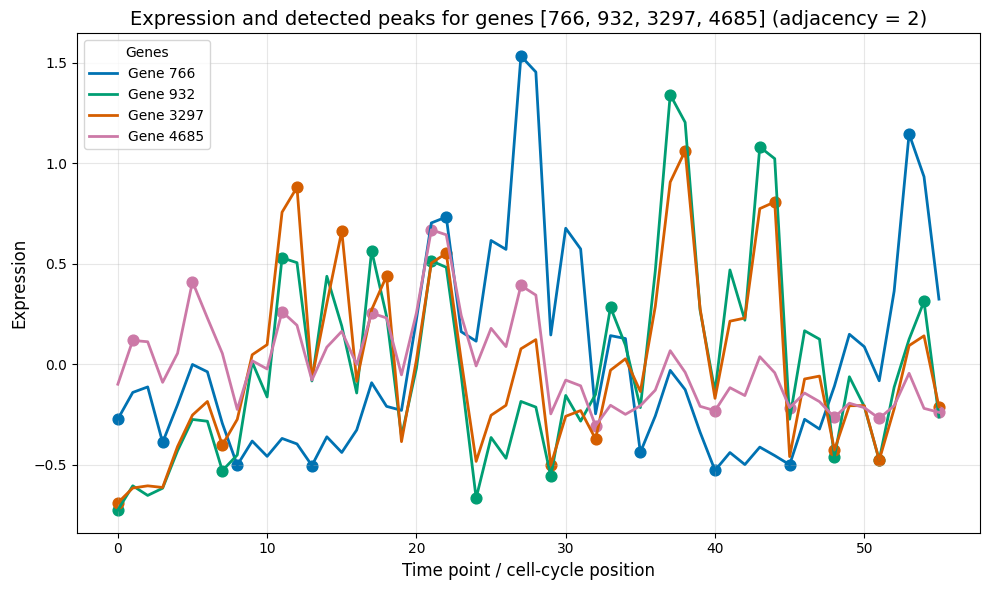

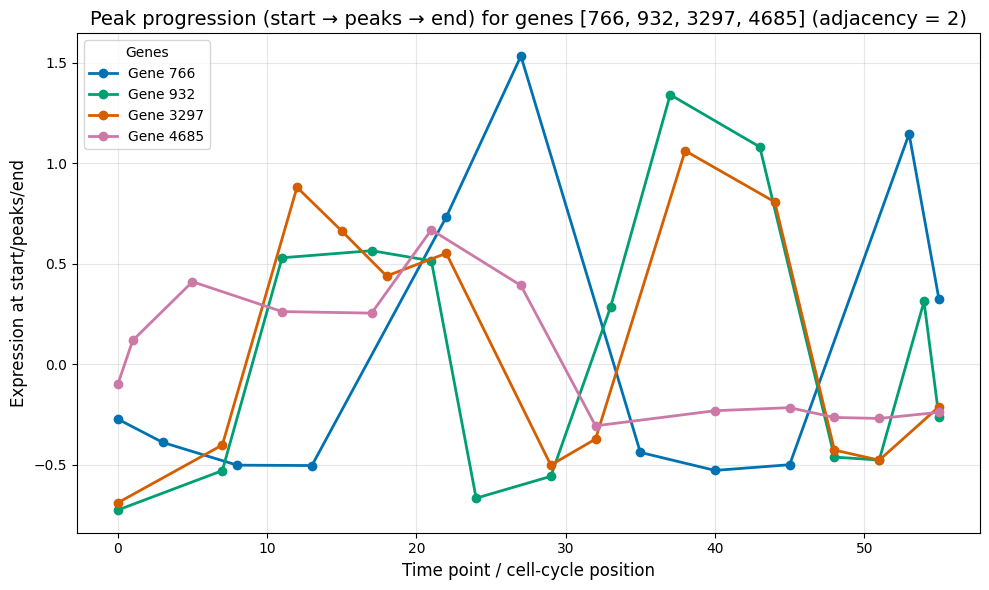

In [73]:
adjacency_for_all =2

plt.style.use("seaborn-v0_8-colorblind")

plt.figure(figsize=(10, 6))

for gene_id in gene_ids:
    expr = expr_df.loc[gene_id].to_numpy()
    timepoints = np.arange(len(expr))

    labels, peak_idx, peak_vals = detect_peaks_watershed_1d(
        expr,
        adjacency_threshold=adjacency_for_all
    )

    (line,) = plt.plot(
        timepoints,
        expr,
        linewidth=2,
        label=f"Gene {gene_id}"
    )

    color = line.get_color()
    plt.scatter(
        peak_idx,
        expr[peak_idx],
        s=60,
        marker="o",
        color=color
    )

plt.xlabel("Time point / cell-cycle position", fontsize=12)
plt.ylabel("Expression", fontsize=12)
plt.title(
    f"Expression and detected peaks for genes {gene_ids} "
    f"(adjacency = {adjacency_for_all})",
    fontsize=14
)
plt.grid(alpha=0.3)
plt.legend(title="Genes", fontsize=10)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))

for gene_id in gene_ids:
    expr = expr_df.loc[gene_id].to_numpy()

    # detect peaks
    labels, peak_idx, peak_vals = detect_peaks_watershed_1d(
        expr,
        adjacency_threshold=adjacency_for_all
    )

    # sort peaks in time-order
    peak_idx_sorted = np.sort(peak_idx)

    # build the sequence: start -> peaks -> end
    # np.unique makes sure we don't duplicate indices if a peak happens
    # to be at the first or last time point
    key_idx = np.unique(
        np.concatenate(([0], peak_idx_sorted, [len(expr) - 1]))
    )

    # x and y values for this summary line
    x_key = key_idx
    y_key = expr[key_idx]

    plt.plot(
        x_key,
        y_key,
        marker="o",
        linewidth=2,
        label=f"Gene {gene_id}"
    )

plt.xlabel("Time point / cell-cycle position", fontsize=12)
plt.ylabel("Expression at start/peaks/end", fontsize=12)
plt.title(
    f"Peak progression (start → peaks → end) for genes {gene_ids} "
    f"(adjacency = {adjacency_for_all})",
    fontsize=14
)
plt.grid(alpha=0.3)
plt.legend(title="Genes", fontsize=10)
plt.tight_layout()
plt.show()


## Interpretation and Conclusions

For the final visualization, I chose an adjacency threshold of `adjacency_threshold = 2`.

From the comparison analysis, this value provides a reasonable compromise:

- `adjacency = 1` → many narrow peaks, clearly over-segmenting small fluctuations
- `adjacency = 2` → captures major peaks while reducing noise sensitivity
- `adjacency = 3-4` → may miss some genuine periodic peaks

The results demonstrate that the selected genes exhibit clear periodic expression patterns synchronized with the cell cycle, with peaks occurring at consistent intervals.
